In [17]:
import pandas as pd

In [18]:
data = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
data.head(5)

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [20]:
data.isnull().sum()

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

In [21]:
data.columns

Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types'],
      dtype='object')

# Feature Extraction:

In [24]:
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

In [25]:
data['time_interval'] = (data['end_time'] - data['creation_time']).dt.total_seconds()

In [26]:
features = ['bytes_in', 'bytes_out', 'protocol', 'time_interval']

In [27]:
feature_data = data[features]

In [28]:
feature_data = pd.get_dummies(feature_data, columns=['protocol'], drop_first=True)

In [30]:
feature_data.head()

,bytes_in,bytes_out,time_interval
0,5602,12990,600.0
1,30912,18186,600.0
2,28506,13468,600.0
3,30546,14278,600.0
4,6526,13892,600.0


# Anomaly detection algorithm

In [31]:
from sklearn.ensemble import IsolationForest

In [32]:
iso_forest = IsolationForest(contamination=0.01)  # Adjust contamination rate as needed

In [33]:
iso_forest.fit(feature_data)

IsolationForest(contamination=0.01)

In [34]:

data['anomaly'] = iso_forest.predict(feature_data)
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})  # 1 for anomaly, 0 for normal

In [36]:
# Display the anomalies
anomalies = data[data['anomaly'] == 1]

In [37]:
anomalies

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,time_interval,anomaly
257,24326941,1529035,2024-04-26 09:30:00+00:00,2024-04-26 09:40:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T09:30:00Z,waf_rule,600.0,1
267,25199191,1557598,2024-04-26 09:40:00+00:00,2024-04-26 09:50:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T09:40:00Z,waf_rule,600.0,1
279,25207794,1561220,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T09:50:00Z,waf_rule,600.0,1


# Evaluation and validation of detected anomalies

### Visualization of Anomalies

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
def plot_anomalies(data, feature_x, feature_y):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=feature_x, y=feature_y, hue='anomaly', palette={0: 'blue', 1: 'red'}, alpha=0.6)
    plt.title(f'Anomalies in {feature_x} vs {feature_y}')
    plt.show()

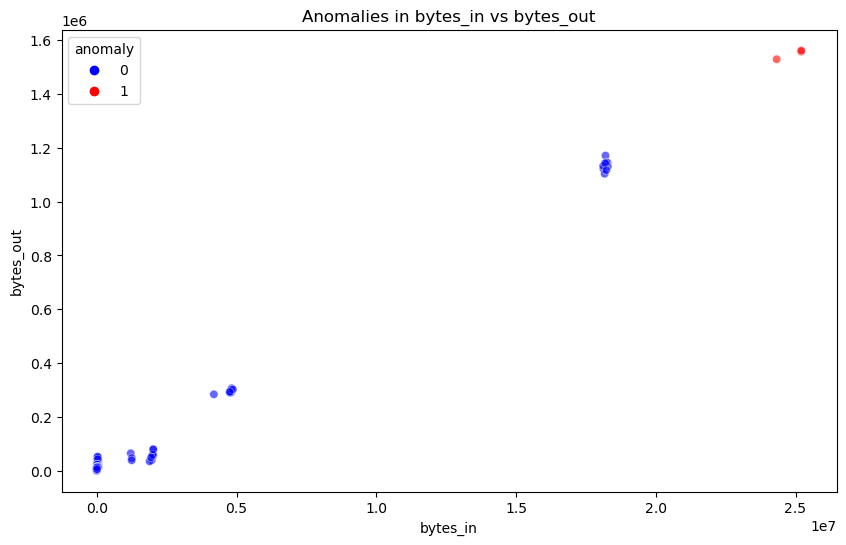

In [44]:
plot_anomalies(data, 'bytes_in', 'bytes_out')

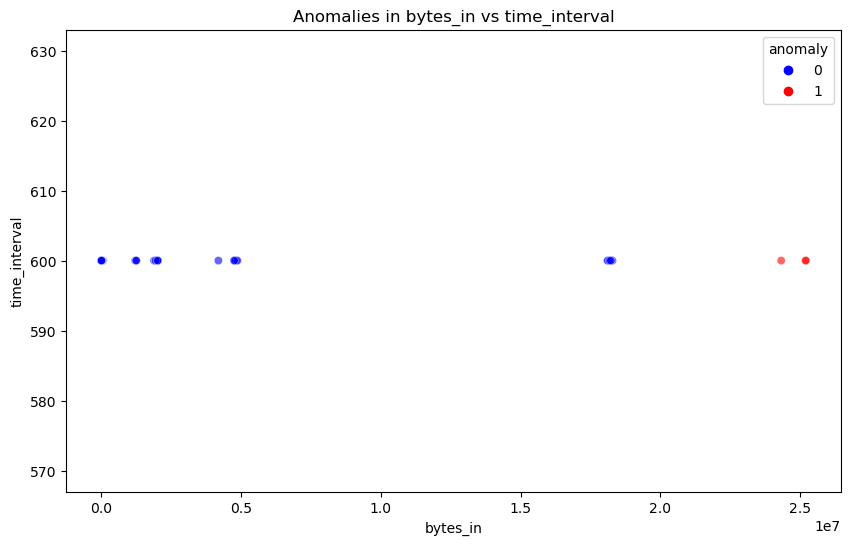

In [45]:
plot_anomalies(data, 'bytes_in', 'time_interval')

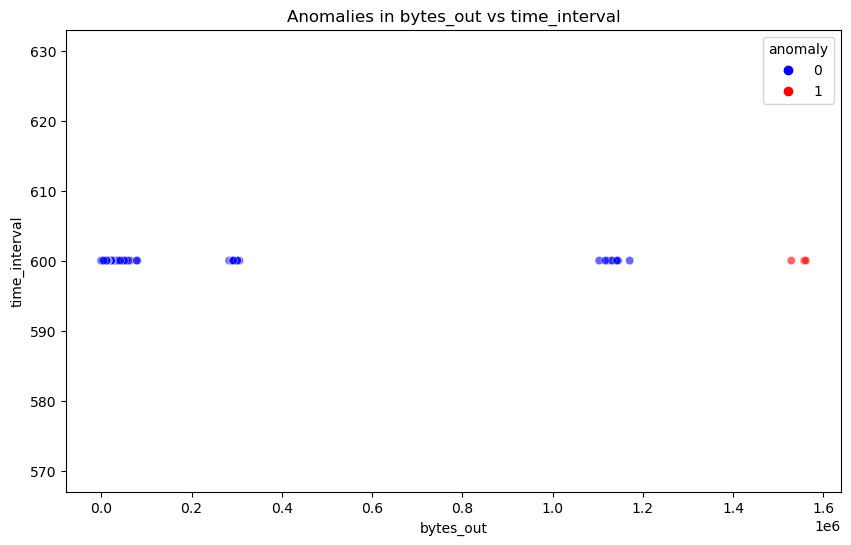

In [46]:
plot_anomalies(data, 'bytes_out', 'time_interval')

### Statistical Analysis

In [47]:
anomalies = data[data['anomaly'] == 1]
normal_data = data[data['anomaly'] == 0]

In [48]:
print("Normal Data Statistics:")
print(normal_data[['bytes_in', 'bytes_out', 'time_interval']].describe())

Normal Data Statistics:
           bytes_in     bytes_out  time_interval
count  2.790000e+02  2.790000e+02          279.0
mean   9.444233e+05  6.880451e+04          600.0
std    3.356784e+06  2.056361e+05            0.0
min    4.000000e+01  4.400000e+01          600.0
25%    5.345000e+03  1.109000e+04          600.0
50%    1.276400e+04  1.357000e+04          600.0
75%    3.049800e+04  2.572250e+04          600.0
max    1.828552e+07  1.170896e+06          600.0


In [49]:
print("\nAnomalies Statistics:")
print(anomalies[['bytes_in', 'bytes_out', 'time_interval']].describe())


Anomalies Statistics:
           bytes_in     bytes_out  time_interval
count  3.000000e+00  3.000000e+00            3.0
mean   2.491131e+07  1.549284e+06          600.0
std    5.060955e+05  1.762970e+04            0.0
min    2.432694e+07  1.529035e+06          600.0
25%    2.476307e+07  1.543316e+06          600.0
50%    2.519919e+07  1.557598e+06          600.0
75%    2.520349e+07  1.559409e+06          600.0
max    2.520779e+07  1.561220e+06          600.0
